# 3. Models for global demand: time series forecasting

**Time series forecasting** help to predict the future values of demand based on previous known values, it is used when the dependend variable varies over time

There are 4 main components that define a Time series:
1. Trend: upward and downward movement of the demand over a period of time
2. Seasonality: seasonal variances of the data
3. Residuals: noise - random variations
4. Cyclicity: the behavior is repeated after an interval of time

## 3.1. Analyzing the time series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the data we created in the first notebook
rides_per_hour = pd.read_csv('movements_grouped.csv')

In [3]:
rides_per_hour = rides_per_hour[['datetime', 'date', 'weekday', 'hour',  'time', 'month', 'is_holiday_x', 'rides', 'year', 'is_weekend']]

In [4]:
rides_per_hour.set_index('datetime', inplace=True)
rides_per_hour.sort_index(inplace=True)

In [5]:
rides_per_hour['weekday'] = rides_per_hour['weekday'].astype('category')

### Autocorrelation plots

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

###### Autocorrelation plot (ACF)

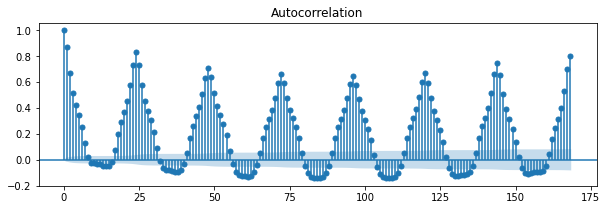

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(rides_per_hour.rides, ax=ax, lags=7*24)
plt.show()

###### Partial Autocorrelation Plot (ACF)

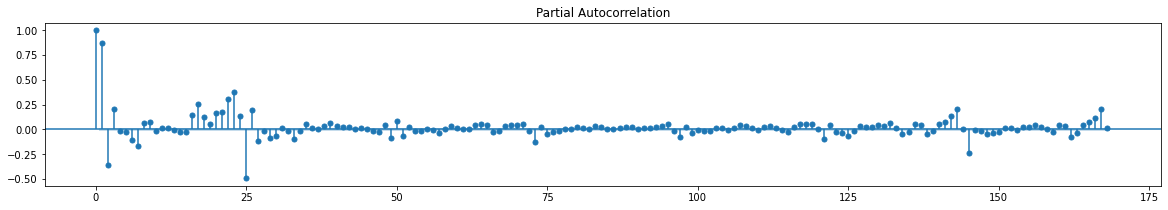

In [8]:
fig, ax = plt.subplots(figsize=(20, 3))
plot_pacf(rides_per_hour.rides, ax=ax, lags=7*24)
plt.show()

From the plots above we can infere that the current value of the time series is highly correlated with the lag 24 (demand at the same time one day before) and lag 164 (demand at the same time 7 days before). There are also high correlation with demand each 24 hours, this indicates that the hour is a quite important feature to predict the demand.

The autocorrelation and partial autocorrelation plots show a clear association between one hour's demand and previous hours, as well as between one hour's demand and the same hour's demand on previous days. **This type of correlation is an indication that autoregressive models can work well.**


### Adding lag values we will use for the model

We are going to use the lag values of the variable rides as predictors in our machine learning models, and also we are going to use them for our naive model. We are going to consider the following lags:

- rides lag 7: 7 days before at the same hour
- rides lag 1: 1 day before at the same hour
- rides lag 2: 2 days before at the same hour
- rides lag 1 month: 1 month before at the same hour
- rides lag 12 hours

In [9]:
rides_per_hour['rides_lag_7'] = rides_per_hour['rides'].shift(7*24)
rides_per_hour['rides_lag_1'] = rides_per_hour['rides'].shift(1*24)
rides_per_hour['rides_lag_2'] = rides_per_hour['rides'].shift(2*24)
rides_per_hour['rides_lag_1_month'] = rides_per_hour['rides'].shift(30*24)
rides_per_hour['rides_lag_12_hours'] = rides_per_hour['rides'].shift(12)

In [10]:
rides_per_hour

,date,weekday,hour,time,month,is_holiday_x,rides,year,is_weekend,rides_lag_7,rides_lag_1,rides_lag_2,rides_lag_1_month,rides_lag_12_hours
datetime,,,,,,,,,,,,,,
2018-12-31 23:00:00,2018-12-31,Monday,23,23:00:00,12,0,176,2018,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:00:00,2019-01-01,Tuesday,0,00:00:00,1,1,254,2019,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,2019-01-01,Tuesday,1,01:00:00,1,1,169,2019,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,2019-01-01,Tuesday,2,02:00:00,1,1,105,2019,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,2019-01-01,Tuesday,3,03:00:00,1,1,83,2019,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,2021-06-30,Wednesday,19,19:00:00,6,0,813,2021,0,814.0,749.0,691.0,610.0,815.0
2021-06-30 20:00:00,2021-06-30,Wednesday,20,20:00:00,6,0,552,2021,0,559.0,581.0,507.0,224.0,565.0
2021-06-30 21:00:00,2021-06-30,Wednesday,21,21:00:00,6,0,571,2021,0,615.0,482.0,400.0,205.0,509.0


###### Let's analyze the correlation between our variables

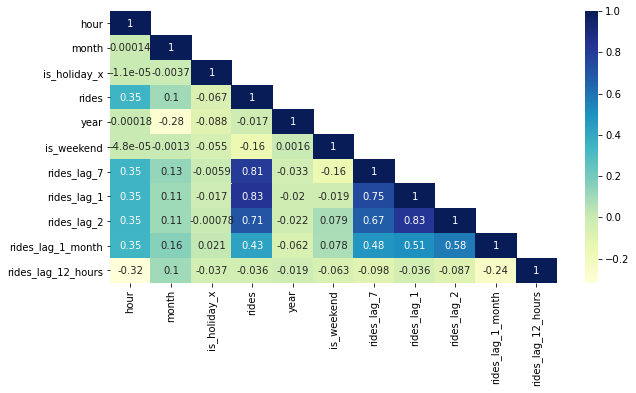

In [11]:
corr_matrix = rides_per_hour.corr()
fig = plt.figure(figsize=(10, 5))

mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_matrix, mask = mask, annot=True, cbar=True,cmap="YlGnBu")
plt.show()

From the correlation matrix we can see that the variable rides we want to predict is highly correlated with.
- rides_lag_7 (demand 7 days before at the same time): coefficient 0.81
- rides_lag_1 (demand 1 day before at the same hour): coefficient 0.83
- rides_lag_2 (demand 2 days before at the same hour): coefficient 0.71

The variable rides is also correlated with:
- rides_lag_1_month (demand one month before at the same hour): coefficient 0.43
- hour: coefficient 0.35

##### Check if the data is stationary

Stationarity is an important concept in the field of time series analysis with influence on how the data is predicted. When forecasting or predicting the future, most time series models assume that each point is independent of one another, and stationarity in time series can assume that the observations are independent.

The data is stationary if the statistical properties not change over time.

To check if the data is stationary we are going to perform the **Dickey-Fuller test**: This test is used to try the null hypotesis: time-series data is non-stationary. It calculates the p-value and compareit with a threshold value of 0.05. If the p-value is lower than this level, data is stationary

In [18]:
from statsmodels.tsa.stattools import adfuller

In [157]:
df_test=adfuller(rides_per_hour['rides'], autolag='AIC', regression = 'ct')
df_test_results = pd.Series(df_test[0:4], index = ['Test statistic', 'p-value', 'Number of lags', 'Number observations'])
for key,value in df_test[4].items():
    df_test_results['Critical value (%s)' %key]=value

In [158]:
#Results of Dickey-Fuller test
df_test_results

Test statistic         -8.521028e+00
p-value                 4.488707e-12
Number of lags          4.700000e+01
Number observations     2.184100e+04
Critical value (1%)    -3.959185e+00
Critical value (5%)    -3.410691e+00
Critical value (10%)   -3.127168e+00
dtype: float64

Conclusions: we reject the null hypotesis and conclude that our **time series is stationary**

Another way for testing stationarity is plotting the moving average and variance and analyze if they do not change over time

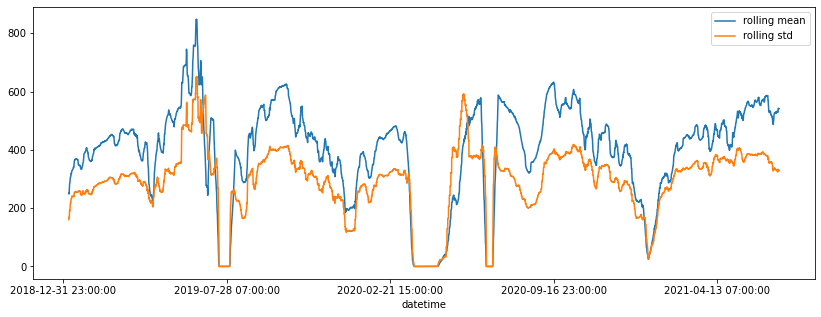

In [17]:
rolmean = rides_per_hour['rides'].rolling(window=24*7).mean()
rolstd = rides_per_hour['rides'].rolling(window=24*7).std()
fig, ax = plt.subplots(figsize=(14, 5))
rolmean.plot(ax=ax, label = 'rolling mean')
rolstd.plot(ax=ax, label = 'rolling std')
plt.legend()
plt.show()

From the plot above we see that the rolling mean and standard deviation have approximately the same trend.

## 3.2. Naive model

We are going to create a naive model that will serve us as a baseline to compare it with the models we are going to build. 

We have just seen that the variable rides is highly correlated with the variable rides_lag_7, which is the demand of bikes at the same hour the week before, so for our naive model we are going to consider that the demand is the same as rides_lag_7

In [19]:
rides_naive=rides_per_hour.dropna(subset=['rides_lag_7'])

In [20]:
rides_naive.columns

Index(['date', 'weekday', 'hour', 'time', 'month', 'is_holiday_x', 'rides',
       'year', 'is_weekend', 'rides_lag_7', 'rides_lag_1', 'rides_lag_2',
       'rides_lag_1_month', 'rides_lag_12_hours'],
      dtype='object')

In [36]:
train_end = 24*14 #14 days
train = rides_naive[:-train_end]
test = rides_naive[-train_end:]
X_train, y_train = train['rides_lag_7'], train['rides']
X_test, y_test = test['rides_lag_7'], test['rides']

In [22]:
predictions = X_test
demand = y_test

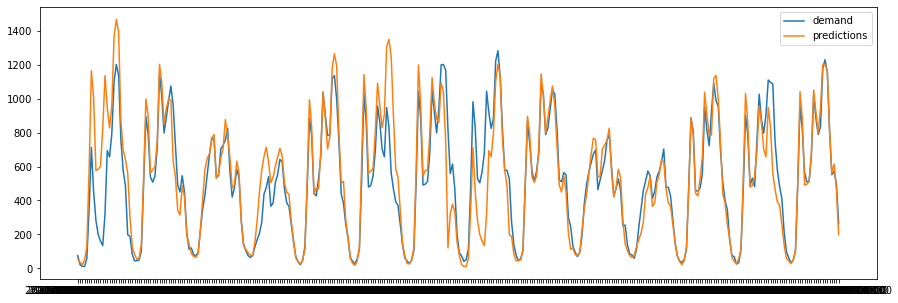

In [24]:
#plot demand vs predictions
fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

###### Evaluating model

We are going to create a dataframe where we are going to add the results of all the models we are going to try. In this dataframe we are going to add the metrics:

- MSE
- MAE
- RMSE
- R2

In [25]:
from sklearn import metrics
def calculate_metrics(forecast,demand):
    mse = metrics.mean_squared_error(forecast,demand)
    mae = metrics.mean_absolute_error(forecast,demand)
    rmse = np.sqrt(metrics.mean_squared_error(forecast,demand))
    r2 = metrics.r2_score(forecast,demand)
    return mse, mae, rmse, r2

In [26]:
evaluation_models = pd.DataFrame(columns=["model", "MSE", "MAE", "RMSE", "R2"])

In [27]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'naive', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)


In [28]:
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749


## 3.3. ARIMA model

ARIMA stands for **Autoregressive Integrated Moving Average Model**.
This model explains a given time series based on its own past values (its own lags and the lagged forecast errors).

ARIMA Models are specified by three order parameters: (p, d, q),

- p is the order of the AR term:  a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series. Refers to the number of lags to be used as predictors


- q is the order of the MA term:  a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.


- d is the number of differencing required to make the time series stationary: uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times. d is the minimun number of differenciating needed to make the series stationary.

### 3.3.1. Parameters for the ARIMA model (p,d,q)

d=0 since data is stationary

##### Obtaining the p

In order to estimate p we use the autocorrelation plot and find the most significant lag in the partial autocorrelation plot.

Partial autocorrelation measures the correlation between two variables after controlling for the effects of other variables.

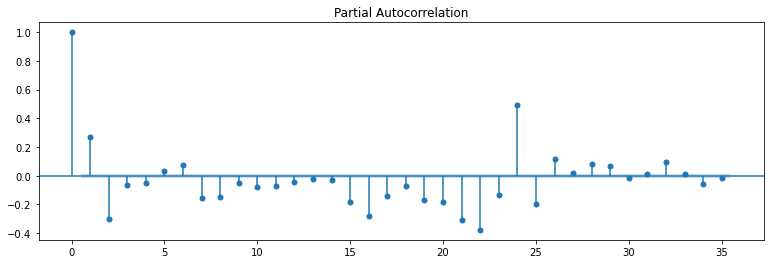

In [29]:
fig, ax = plt.subplots(figsize=(13, 4))
plot_pacf(rides_per_hour['rides'].diff(1).dropna(), lags=35, ax=ax)
plt.show()

From the plot we see that the 24th lag is the most significant, so we consider p =24.

##### Obtaining the q

For estimating q we are going to use the ACF plot, taking into account the number of lags crossing the threshold, so we determine how much of the mast would be significant enough to consider for the future. Those with higher correlation contribute more and would be enough to predict the future.

The ACF function is used to identify the level of correlation of the values in a time series with each other. The autocorrelation plot shows the correlation coefficient against the lags (measured in number of periods, in this case one lag is one hour).
\

0 value means that there is not correlation.
Blue band represent error bands, any line inside these area is not significant, lines outside this area are very likely a correlation

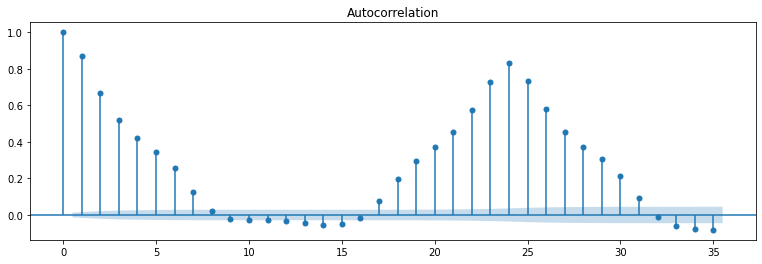

In [30]:
fig, ax = plt.subplots(figsize=(13, 4))
plot_acf(rides_per_hour['rides'], lags=35, ax=ax)
plt.show()

We select the parameter q=6

### 3.3.2. Model

In [37]:
from statsmodels.tsa.arima_model import ARIMA

In [38]:
#For arima model we only need one variable 'rides', the variable we want to predict
train_arima=train['rides']
test_arima=test['rides']

In [40]:
arima_model = ARIMA(train_arima, order=(24,0,6))

C:\Users\paula\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [41]:
model_fit = arima_model.fit()

In [42]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  rides   No. Observations:                21385
Model:                    ARMA(24, 6)   Log Likelihood             -130403.450
Method:                       css-mle   S.D. of innovations            107.608
Date:                Sat, 11 Jun 2022   AIC                         260870.900
Time:                        10:16:27   BIC                         261125.954
Sample:                    01-07-2019   HQIC                        260954.076
                         - 06-16-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          396.6481     26.618     14.902      0.000     344.478     448.818
ar.L1.rides      0.0120      0.007      1.659      0.097      -0.002       0.026
ar.L2.rides      0.0140      0.007      1.90

The first table represent general information about the model.
The dependent variable are the rides, which we want to predict, while the independent variables are the constant beta.
Our lag variables are ar.

In the table on the middle we can observe the term significance and the weight of the coefficients used in the model. We want that each term in the model is statistically significant. The null hypotesis is that each coefficient is not statistically significant, so we want to reject the null hypotesis, so the p-value of each term to be lower han 0.05.

From the results we can see that ar.L1, ar.L2, ar.L3, ar.L7, ar.L12, ar.L13, ar.L14, ar.L15, ma.L6 are not statistically significant as their p-values are above 0.05.

The most important coefficients are ar.L24 (coefficient = 0.6893) and ma.L1 (coefficient = 1.1000)

We are going to analyze the residuals, to ensure that there are no patterns (we want them to be **white noise**)

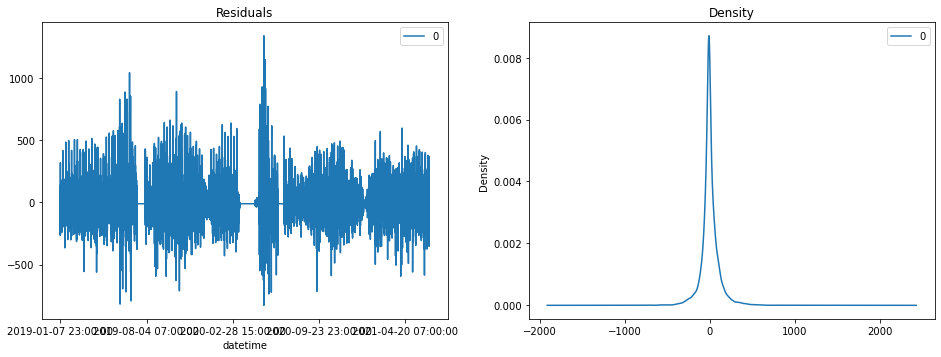

In [52]:
residuals = pd.DataFrame(model_fit.resid)
fig = plt.figure(figsize=(16,12))
axes = fig.add_subplot(2,2,1)

residuals.plot(title = "Residuals", ax = axes)
axes = fig.add_subplot(2,2,2)
residuals.plot(kind = 'kde', title = 'Density', ax = axes)
plt.show()

The residual errors have a near zero mean (as we can see in the plots above) and uniform vasiance, so we can say that the residuals are white noise

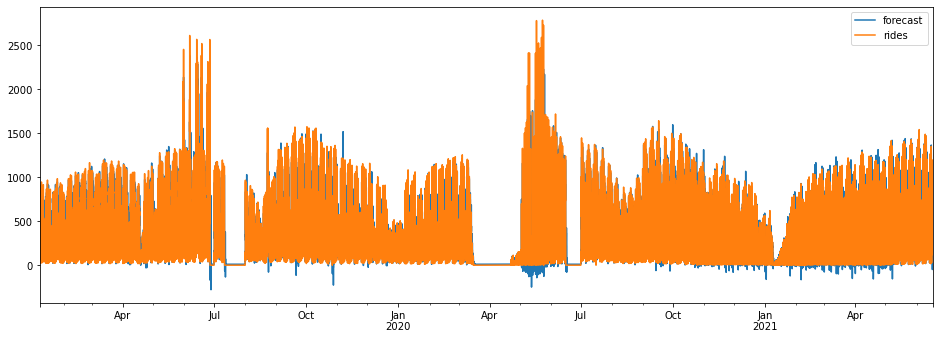

In [55]:
fig = plt.figure(figsize=(16,12))
axes = fig.add_subplot(2,1,1)
model_fit.plot_predict(dynamic=False, ax = axes) 
plt.show()

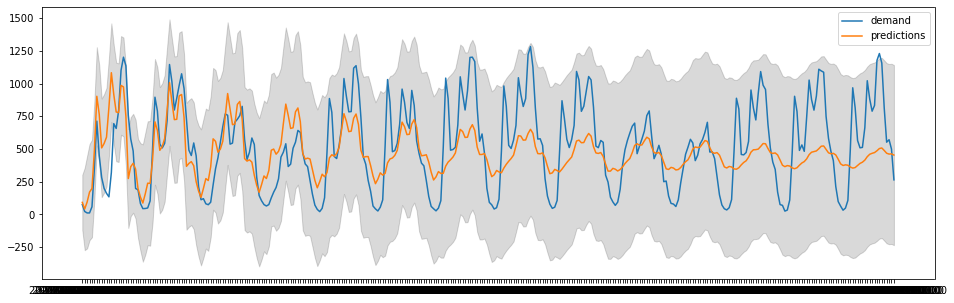

In [72]:
predictions, se, confidence = model_fit.forecast(len(test),alpha = 0.05) #95% confidence
predictions = pd.Series(predictions, index=test_arima.index)
lower_band = pd.Series(confidence[:,0], index = test_arima.index)
upper_band = pd.Series(confidence[:,1], index=test_arima.index)

#Plot of predictions vs real demand and the interval of 95% confidence
plt.figure(figsize=(16,5))
plt.plot(test_arima, label = 'demand')
plt.plot(predictions, label ='predictions')
plt.fill_between(lower_band.index, lower_band,upper_band, color='k', alpha=.15)
plt.legend()
plt.show()

In [73]:
# Evaluating the model
mse, mae, rmse, r2 = calculate_metrics(predictions, test_arima)
evaluation_models = evaluation_models.append({'model':'ARIMA (24,0,6)', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)

In [74]:
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533


The metrics are worse than the naive model that we have developed before, moreover, in the figure it can be observed that for values close to the initial date the model adapts better than as time progresses, where it is observed that the predictions are increasingly farther away from the real demand, and tend towards the average.

Let's try another type of model to predict demand.

## 3.4. Machine Learning Models

Advantages of using Machine learning methods for forecasting.
* Ease of including exogenous variables in addition to autoregressive variables
* Allows the incorporation of non-linear behaviors
* High scalability, useful when large amount of data is available

There are also some disadvantages for this:

* Restructuring the data to fit a regression problem
* Iterative processes are needed, each prediction uses the previous predictions
* Validation requires specific strategies. Traditional cross validation does not work

The forecast in a time series can be decomposed in two parts:
    
    Forecast = patterns (explained variance) + unexplained variance
    
* Patterns: it has a repetitive character over time (trend, seasonality, cyclical values)
* Unexplained variance: influences the target variable but cannot be explained by the past

The higher the importance of the patterns, the higher the probability of creating autorregresive forecasting models. The higher the importance of the unexplained variance requires to incorporate additional variables to the model, to help to understand the observed values

It's importat to control the bias and variance of the model. Small trees (few braches) have low variance but fail to represent well the relationship between variables (high bias). On the other hand, large trees are very close to the training data, so they will propably have high variance. We need to control the balance between bias and variance this can be solved with ensemble methods.

Ensemble methods combine multiple models in a new one, with the aim of balancing bias and variance. Typeas of ensembling methods:

1. Bagging: multiple models are fitted, each with a different subset of the training data. As a final value, the mean of all predictions is taken. Random Forest belong to this category
2. Boosting: multiple simple models are adjusted sequentially, so each model learns from the errors of the previous one. Finally, the mean of all predictions is taken. Gradient Boosting belong to this category

We need to transform the temporal series in a matrix, where each value is related to the precedent lags

### 3.4.1. Random Forest 

Random Forest is a non parametric method, so no specific distribution is required. Also, this type of models require less data cleaning and preprocessing compared to other statistical methods, this models do not require standarization.
They are not greatly influenced by outliers.

First we need to prepare the data for the model. 

To take into account the day of the week we are going to perform a One-hot encoding, this process takes categorical variables and converts it to numerical representation without an arbitrary ordering.

We are going to perform the One Hot Encoding for the columns:

- Weekday
- Month
- Hour

This way the model is giving the same importances to all the variables

In [75]:
#Libraries
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import warnings
warnings.filterwarnings('ignore')
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [76]:
#One hot encoding for categorical variables
rides_per_hour = pd.get_dummies(rides_per_hour, columns=['weekday', 'hour', 'month'])

In [168]:
#We save the columns we are using as predictors in columns for model and the target we want to predict in target
columns_for_model = [column for column in rides_per_hour.columns
                      if column.startswith(('weekday', 'hour', 'month'))]


target = 'rides'

In [78]:
rides_per_hour_models = rides_per_hour.dropna(subset = ['rides_lag_7'])

In [174]:
rides_per_hour_models['rides_lag_7'] = rides_per_hour_models['rides_lag_7'].astype(int)
rides_per_hour_models['rides_lag_1'] = rides_per_hour_models['rides_lag_1'].astype(int)

In [80]:
#Verification that the temporal series is complete
(rides_per_hour.index==pd.date_range(start = rides_per_hour.index.min(),
                                   end = rides_per_hour.index.max(),
                                   freq='1H')
).all()

True

In [81]:
#Division of the dataset in train and test
train_end = 14*24 #14 days
train = rides_per_hour_models[:-train_end]
test = rides_per_hour_models[-train_end:]

In [82]:
X_train, y_train = train[columns_for_model], train[target]
X_test, y_test = test[columns_for_model], test[target]

A ForecasterAutoreg is created and trained from a RandomForestRegressor and a time window of 24*7 lags, using the past 7 days demand at the same hour as predictors, because we saw in the correlation matrix that the demand is correlated with these lags

In [83]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),
                              lags = [24,24*2,24*3,24*4,24*5,24*6,24*7])

forecaster.fit(y_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 24  48  72  96 120 144 168] 
Window size: 168 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 21384] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-11 11:29:53 
Last fit date: 2022-06-11 11:30:00 
Skforecast version: 0.4.3 

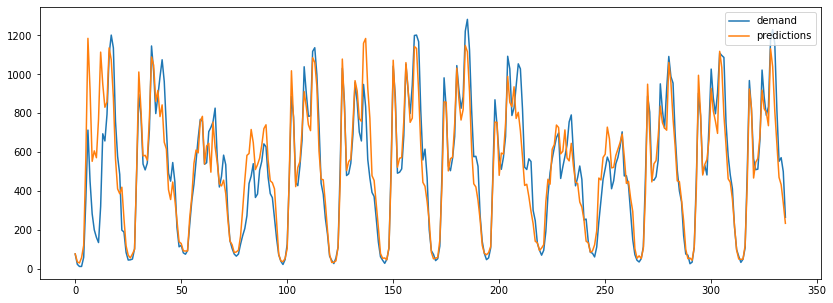

In [84]:
#Prediction of test
predictions = forecaster.predict(steps=len(X_test))
predictions = predictions.reset_index()
predictions = predictions['pred']
#Demand
demand = y_test
demand = demand.reset_index()
demand = demand['rides']
#Plot demand and predictions
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')

ax.legend()
plt.show()

In [85]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'Random Forest', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533
2,Random Forest,16884.489419,86.475893,129.940330,0.823262


Using the forecaster autorregresor with a Random Forest we have reduced the mse to 43%. We also improved all the metrics: MSE, MAE, RMSE and R2.

### Hyperparameters

We are going to search for the best hyperparameters for the model and the number of lags required, for this we are going to perform a **grid search**.

In [76]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),
                              lags =24*7)

#Lags used as predictors
possible_lags = [24*7, 24*1]

#hyperparameters of regressor
param_grid = {'n_estimators':[100,500],
             'max_depth': [3,5,10]}

grid_results = grid_search_forecaster(forecaster = forecaster,
                                     y = y_train,
                                     param_grid = param_grid,
                                     lags_grid = possible_lags,
                                     steps = 24,
                                     refit = False,
                                     metric = 'mean_squared_error',
                                     initial_train_size=int(len(X_train)*0.5),
                                     fixed_train_size = False,
                                     return_best=True,
                                     verbose=False
                                     )

loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]

Number of models compared: 12



loop lags_grid: 100%|█████████████████████████████████████| 2/2 [56:45<00:00, 1702.57s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 27989.583686102673



In [77]:
#Results of the grid search
grid_results

,lags,params,metric,max_depth,n_estimators
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",27989.583686,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",28265.023964,10,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",35396.643364,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",35832.724460,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",38494.623505,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",39094.980347,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",67504.288774,5,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",68005.898694,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",68481.216770,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",70320.263214,5,100


Best results are the ones that use a lag and the hyperparameters:
* max_depth: 10
* n_estimators: 500

##### Final model

Once we've found the best combination of hyperparameters, we train a new ForecasterAutoreg and plot the results

In [93]:
regressor = RandomForestRegressor(max_depth=10,n_estimators =50, random_state=123)
forecaster = ForecasterAutoreg(regressor=regressor,
                              lags=24*7)
forecaster.fit(y=y_train)

In [101]:
predictions = forecaster.predict_interval(steps = len(X_test), interval =[5,95])
predictions

KeyboardInterrupt: 

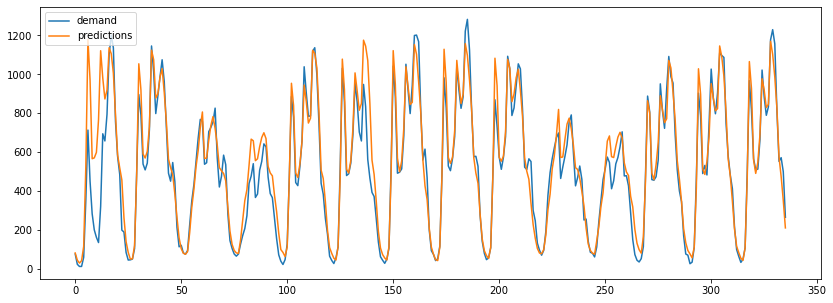

In [103]:
predictions = forecaster.predict(steps=len(X_test))
predictions = predictions.reset_index()
predictions = predictions['pred']
demand = y_test
demand = demand.reset_index()
demand = demand['rides']

#Demand vs predictions
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [88]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'Random Forest grid search', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533
2,Random Forest,16884.489419,86.475893,129.940330,0.823262
3,Random Forest grid search,13062.952660,69.379588,114.293275,0.880072


With the grid search, we have improved our model by 8% in terms of MSE. And the model improved the naive model in a 47%.

###### Feature importance

Now we are going to evaluate the importance of the predictors

In [105]:
predictors_importance = forecaster.get_feature_importance()
predictors_importance = predictors_importance.sort_values(by='importance', ascending = False)
predictors_importance = predictors_importance.head(10)

In [106]:
predictors_importance

,feature,importance
0,lag_1,0.651705
167,lag_168,0.161130
23,lag_24,0.101823
166,lag_167,0.008942
22,lag_23,0.005712
143,lag_144,0.005050
25,lag_26,0.003253
24,lag_25,0.002870
95,lag_96,0.002618
1,lag_2,0.002270


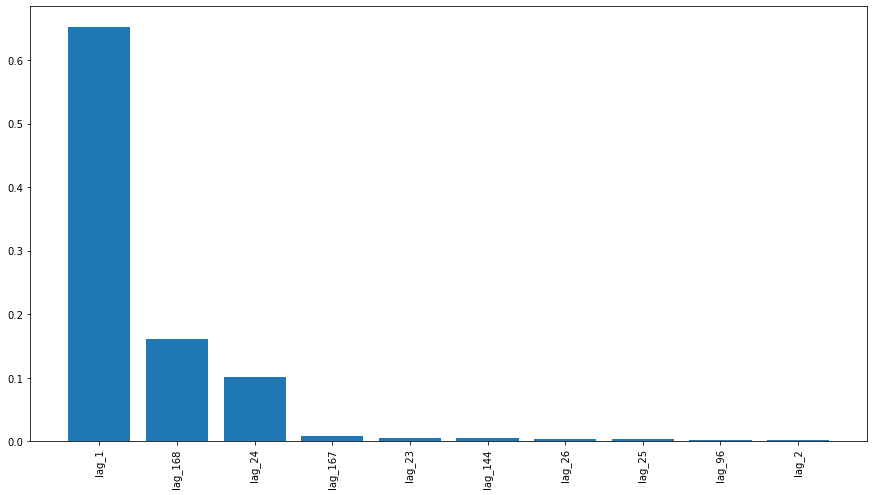

In [107]:
plt.figure(figsize=(15,8))
plt.bar(predictors_importance['feature'], height = predictors_importance['importance']);
plt.xticks(rotation=90);

The most influential variable in the model is the previous day's demand at the same time (lag 1), with an importance of the 65%

##### Adding exogenous variables to the model

For the previous model we only take into account the lag values as predictors, now we are going to add exogenous variables, that we know in advance.

We are going to add the variables:

- Hour 
- Month
- is_weekend
- weekday

In [108]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),
                            lags = [24, 24*7])
forecaster.fit(y = y_train, exog = X_train[columns_for_model])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 24 168] 
Window size: 168 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['weekday_Friday', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'is_holiday_x', 'is_weekend'] 
Training range: [0, 21384] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'aut

In [109]:
#Prediction of test
predictions = forecaster.predict(steps = len(X_test), exog = X_test[columns_for_model])
predictions = predictions.reset_index()
predictions = predictions['pred']
demand = y_test
demand = demand.reset_index()
demand = demand['rides']

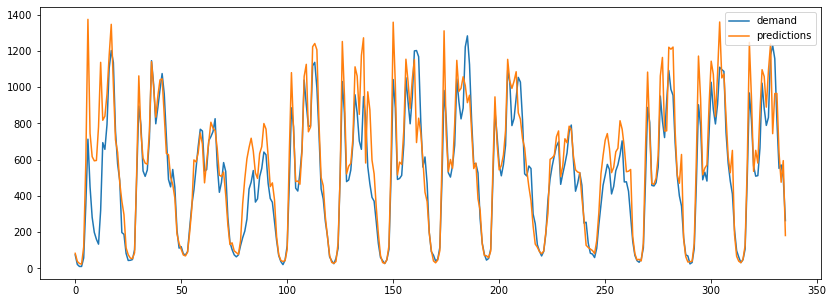

In [110]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [111]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'Random forest with exog. variables', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533
2,Random Forest,16884.489419,86.475893,129.940330,0.823262
3,Random Forest grid search,13062.952660,69.379588,114.293275,0.880072
4,Random forest with exog. variables,22295.132267,99.223988,149.315546,0.825744


This model with exogenous variables has worse results than the previous models, then we will perform a grid search to find the best hyperparameters of the model and improve the metrics.

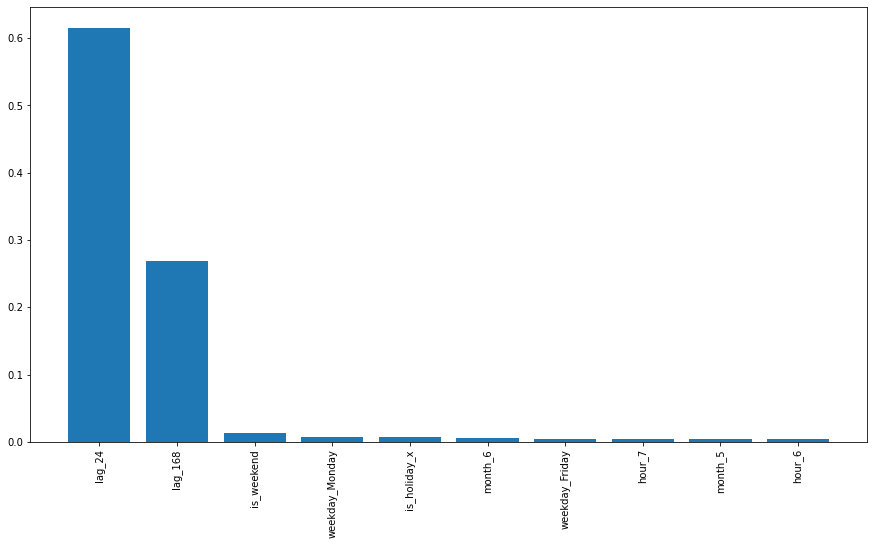

In [96]:
#Feature importance
predictors_importance = forecaster.get_feature_importance()
predictors_importance = predictors_importance.sort_values(by='importance', ascending = False)
predictors_importance = predictors_importance.head(10)

plt.figure(figsize=(15,8))
plt.bar(predictors_importance['feature'], height = predictors_importance['importance']);
plt.xticks(rotation=90);

###### Grid search to find the best combination of hyperparameters

In [112]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),
                              lags = [24*7])
#Number of lags used as predictors
lags_grid = [[24,24*7], [24*7]]

#Regressor hyperparameters
param_grid = {'n_estimators':[100,200,500],
             'max_depth': [3,5,10]}

#Grid search
grid_seach = grid_search_forecaster(forecaster = forecaster,
                                   y = train['rides'],
                                   exog = train[columns_for_model],
                                   param_grid = param_grid,
                                   lags_grid = lags_grid,
                                   steps = 24,
                                   refit = False,
                                   metric = 'mean_squared_error',
                                   initial_train_size = int(len(train)*0.25),
                                   fixed_train_size=False,
                                   return_best=True,
                                   verbose=False)

loop param_grid:   0%|                                              | 0/9 [00:00<?, ?it/s]

Number of models compared: 18



loop lags_grid:   0%|                                               | 0/2 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [100]:
grid_seach

,lags,params,metric,max_depth,n_estimators
3,"[24, 168]","{'max_depth': 5, 'n_estimators': 100}",22184.005696,5,100
4,"[24, 168]","{'max_depth': 5, 'n_estimators': 200}",22348.191738,5,200
5,"[24, 168]","{'max_depth': 5, 'n_estimators': 500}",22461.213426,5,500
8,"[24, 168]","{'max_depth': 10, 'n_estimators': 500}",22967.883515,10,500
6,"[24, 168]","{'max_depth': 10, 'n_estimators': 100}",23013.582041,10,100
7,"[24, 168]","{'max_depth': 10, 'n_estimators': 200}",23141.271652,10,200
1,"[24, 168]","{'max_depth': 3, 'n_estimators': 200}",27208.413391,3,200
2,"[24, 168]","{'max_depth': 3, 'n_estimators': 500}",27345.549048,3,500
0,"[24, 168]","{'max_depth': 3, 'n_estimators': 100}",27346.208571,3,100
14,[168],"{'max_depth': 5, 'n_estimators': 500}",42232.664186,5,500


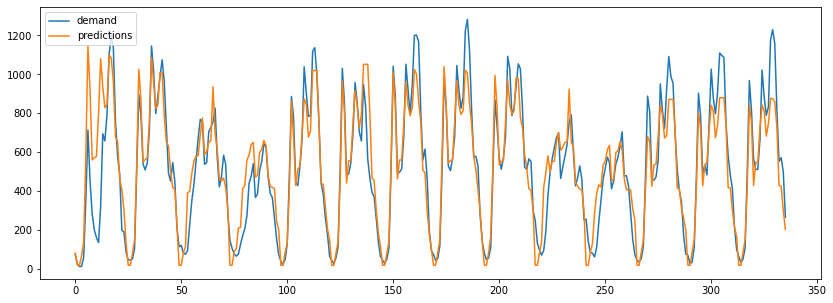

In [115]:
#Prediction of test
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123, max_depth =5, n_estimators=100),
                              lags = [24,24*7])

forecaster.fit(y=train['rides'], exog = train[columns_for_model])

predictions = forecaster.predict(steps = len(X_test), exog = X_test[columns_for_model])
predictions = predictions.reset_index()
predictions = predictions['pred']
demand = y_test
demand = demand.reset_index()
demand = demand['rides']

fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [116]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'Random Forest with exog. variables grid search', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533
2,Random Forest,16884.489419,86.475893,129.940330,0.823262
3,Random Forest grid search,13062.952660,69.379588,114.293275,0.880072
4,Random forest with exog. variables,22295.132267,99.223988,149.315546,0.825744
5,Random Forest with exog. variables grid search,18056.844368,93.056430,134.375758,0.796471


Adding exogenous variables improved our metrics compared to the naive model, but the results with the Random forest without exogenous variables provided better results

###### Saving the results of the best model of Random Forest in a csv file

In [118]:
#creating and training the forecaster

regressor = RandomForestRegressor(max_depth=10,n_estimators =50, random_state=123)
forecaster = ForecasterAutoreg(regressor=regressor,
                              lags=24*7)
forecaster.fit(y=y_train)

#Obtaining exogenous variables for the model
steps = len(X_test)
last_day_data = rides_per_hour[-1:]
last_day_data = last_day_data.index[0]

exogenous_variables = pd.date_range(last_day_data, periods = 365*24,freq='H')
exogenous_variables = pd.DataFrame(exogenous_variables, columns = ['datetime'])
exogenous_variables = exogenous_variables[1:]
exogenous_variables['hour'] = exogenous_variables['datetime'].dt.hour
exogenous_variables['month'] = exogenous_variables['datetime'].dt.month
exogenous_variables['weekday'] = exogenous_variables['datetime'].dt.day_name()
exogenous_variables.reset_index(inplace=True)
exogenous_variables = pd.get_dummies(exogenous_variables, columns = ['weekday', 'hour', 'month'])
exogenous_variables = exogenous_variables[:steps]

#Obtaining the predictions and save them in the csv
predictions = forecaster.predict(steps=steps)
predictions = predictions.reset_index()

global_predictions = pd.concat([predictions, exogenous_variables], axis = 1)
global_predictions = global_predictions[['pred', 'datetime']]
global_predictions['hour'] = global_predictions['datetime'].dt.hour
global_predictions['day'] = global_predictions['datetime'].dt.date
global_predictions['model'] = 'Random Forest'

predictions_all_stations = global_predictions
predictions_all_stations.to_csv("predictions_all_stations.csv")

In [119]:
predictions_all_stations

,pred,datetime,hour,day,model
0,80.293696,2021-07-01 00:00:00,0,2021-07-01,Random Forest
1,43.352614,2021-07-01 01:00:00,1,2021-07-01,Random Forest
2,28.451396,2021-07-01 02:00:00,2,2021-07-01,Random Forest
3,40.465603,2021-07-01 03:00:00,3,2021-07-01,Random Forest
4,113.962771,2021-07-01 04:00:00,4,2021-07-01,Random Forest
...,...,...,...,...,...
331,826.025048,2021-07-14 19:00:00,19,2021-07-14,Random Forest
332,573.288594,2021-07-14 20:00:00,20,2021-07-14,Random Forest
333,473.987663,2021-07-14 21:00:00,21,2021-07-14,Random Forest
334,350.968723,2021-07-14 22:00:00,22,2021-07-14,Random Forest


### 3.4.2. Extreme gradient Boosting

A Gradient Boosting Decision Trees (GBDT) is a decision tree ensemble learning algorithm similar to random forest, it can be used for classification and regression. Ensemble learning algorithms combine multiple machine learning algorithms to obtain a better model.

GBDT, as Random Forest,  build a model consisting of multiple decision trees. The difference is in how the trees are built and combined.

GBDTs iteratively train an ensemble of shallow decision trees, with each iteration using the error residuals of the previous model to fit the next model. The final prediction is a weighted sum of all of the tree predictions

To implement the models we used the scikitlearn library, with the following regressors:

•	XGBoost (Extreme Gradient Boosting): uses a presorted algorithm and histogram-based algorithm for comuting the best splits.

•	CatBoost: builds symmetric (balanced) trees, unlike XGBoost and LightGBM. In every step, leaves from the previous tree are split using the same condition.

•	LightGBM: uses a novel technique of Gradient-base One-Side Sample to filter the data instances for finding a split value


#### 3.4.2.1. XGBoost

As a first approach to this model, we are going to use the lag values of the variable 'rides' to predict future values, and then we will include exogenous variables

In [120]:
from xgboost import XGBRegressor

In [121]:
forecaster = ForecasterAutoreg(regressor = XGBRegressor(random_state=123),
                              lags = [24, 24*7])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 24 168] 
Window size: 168 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'object

In [124]:
#Grid search to find best hyperparameters

#regressor parameters
param_grid = {'n_estimators': [100,500],
             'max_depth': [3,5,10],
             'learning_rate': [0.01,0.1]}

#number of lags
lags_grid = [[24, 24*7]]

grid_search = grid_search_forecaster(forecaster = forecaster,
                                    y = y_train,
                                    param_grid=param_grid,
                                    lags_grid = lags_grid,
                                    steps = 24,
                                    refit=False,
                                    metric = 'mean_squared_error',
                                    initial_train_size = len(y_train)-1,
                                    return_best = True,
                                    verbose=False)

loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Number of models compared: 12



loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:14<00:00, 14.83s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 24 168] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 60.3184407169465



In [107]:
grid_search.head()

,lags,params,metric,learning_rate,max_depth,n_estimators
0,"[24, 168]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",60.318441,0.01,3.0,100.0
4,"[24, 168]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",83.389313,0.01,10.0,100.0
2,"[24, 168]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",172.692468,0.01,5.0,100.0
1,"[24, 168]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",3142.663448,0.01,3.0,500.0
6,"[24, 168]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",4025.772379,0.10,3.0,100.0


###### Backtesting

To evaluate the predictive capacity of the model, we are going to use the backtesting forecaster, so we can simulate the prediction process each 24 hours.

In [125]:
#Backtesting
metric, predictions = backtesting_forecaster(forecaster = forecaster,
                                            y = y_train,
                                            initial_train_size = len(y_train)-1,
                                            steps = 24,
                                            refit = False,
                                            metric = 'mean_squared_error',
                                            verbose = False)

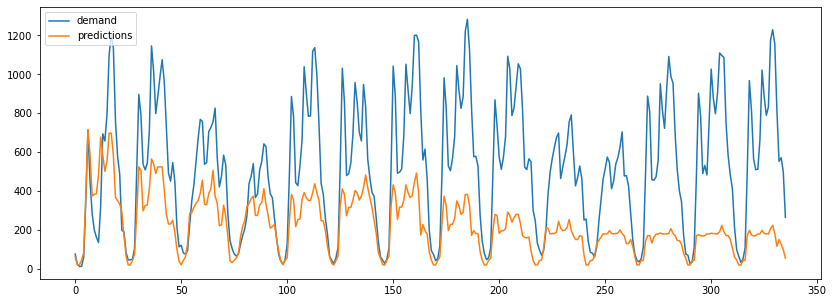

In [126]:
predictions = forecaster.predict(steps = len(X_test))
predictions = predictions.reset_index()
predictions = predictions['pred']
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [127]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'XGBoost', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533
2,Random Forest,16884.489419,86.475893,129.940330,0.823262
3,Random Forest grid search,13062.952660,69.379588,114.293275,0.880072
4,Random forest with exog. variables,22295.132267,99.223988,149.315546,0.825744
5,Random Forest with exog. variables grid search,18056.844368,93.056430,134.375758,0.796471
6,XGBoost,155785.599825,310.201150,394.696845,-6.386980


The XGBoost without including exogenous variables has worse results than all the previous models we've tried. Now we are going to add exogenous variables and see if we can improve the model

##### Adding exogenous variables

In [129]:
param_grid = {
    'n_estimators': [100,500],
    'max_depth': [3,5,10],
    'learning_rate': [0.01,0.1]
}

lags_grid = [[24,24*7],[24*7]]

grid_search = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = y_train,
                        exog               = X_train[columns_for_model],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 24,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(X_train)) -1,
                        return_best        = True,
                        verbose            = False
                   )

loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Number of models compared: 24



loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:29<00:00, 44.85s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [168] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 15.67814872507006



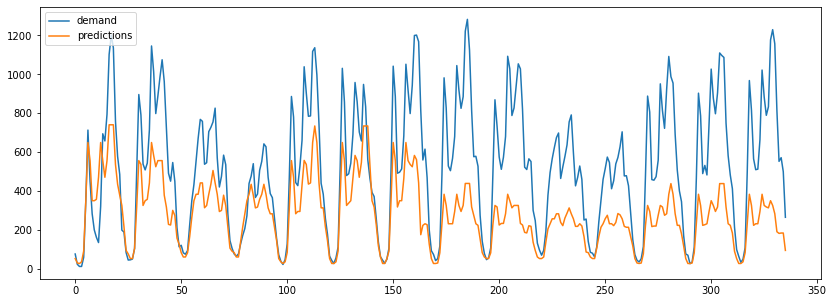

In [130]:
predictions = forecaster.predict(steps = len(X_test), exog = X_test[columns_for_model])
predictions = predictions.reset_index()
predictions = predictions['pred']
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [132]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'XGBoost with exog', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533
2,Random Forest,16884.489419,86.475893,129.940330,0.823262
3,Random Forest grid search,13062.952660,69.379588,114.293275,0.880072
4,Random forest with exog. variables,22295.132267,99.223988,149.315546,0.825744
5,Random Forest with exog. variables grid search,18056.844368,93.056430,134.375758,0.796471
6,XGBoost,155785.599825,310.201150,394.696845,-6.386980
7,XGBoost with exog,106101.932726,251.882481,325.732916,-2.662770
8,XGBoost with exog,106101.932726,251.882481,325.732916,-2.662770


#### 3.4.2.2. Light GBM

In [133]:
#pip install lightgbm
from lightgbm import LGBMRegressor

In [134]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),
                              lags=[24,24*7])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 24 168] 
Window size: 168 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-06-11 12:56:53 
Last fit date: None 
Skforecast version: 0.4.3 

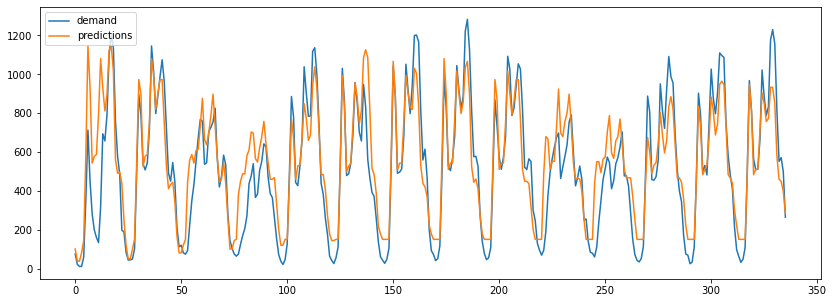

In [136]:
forecaster.fit(y=y_train)
predictions = forecaster.predict(steps=len(X_test))
predictions = predictions.reset_index()
predictions = predictions['pred']
demand = y_test
demand = demand.reset_index()
demand = demand['rides']
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [137]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'Light GBM', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533
2,Random Forest,16884.489419,86.475893,129.940330,0.823262
3,Random Forest grid search,13062.952660,69.379588,114.293275,0.880072
4,Random forest with exog. variables,22295.132267,99.223988,149.315546,0.825744
5,Random Forest with exog. variables grid search,18056.844368,93.056430,134.375758,0.796471
6,XGBoost,155785.599825,310.201150,394.696845,-6.386980
7,XGBoost with exog,106101.932726,251.882481,325.732916,-2.662770
8,XGBoost with exog,106101.932726,251.882481,325.732916,-2.662770
9,Light GBM,23815.884251,111.858306,154.323959,0.699046


The model offered better results than the XGBoost, ARIMA and naive model, but it has worse results than the Random Forest.

### Hyperparameters

In [139]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(),
                              lags=[24,24*7])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor() 
Lags: [ 24 168] 
Window size: 168 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-06-11 12:58:08 
Last fit date: None 
Skforecast version: 0.4.3 

In [140]:

param_grid = {
    'max_iter': [100,500],
    'max_depth':[3,10],
    'learning_rate':[0.01,0.1]
}

possible_lags = [24,24*7]


results_grid = grid_search_forecaster(forecaster = forecaster,
                                     y = y_train,
                                     param_grid = param_grid,
                                     lags_grid = possible_lags,
                                     steps=len(X_test),
                                     refit=False,
                                     metric = 'mean_absolute_error',
                                     initial_train_size=int(len(X_train)*0.25),
                                     return_best=True,
                                     verbose=False)

loop param_grid:   0%|                                              | 0/8 [00:00<?, ?it/s]

Number of models compared: 16
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  12%|████▊                                 | 1/8 [00:01<00:11,  1.64s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  25%|█████████▌                            | 2/8 [00:03<00:11,  1.87s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  38%|██████████████▎                       | 3/8 [00:05<00:09,  1.84s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  50%|███████████████████                   | 4/8 [00:08<00:09,  2.28s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  62%|███████████████████████▊              | 5/8 [00:10<00:06,  2.13s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  75%|████████████████████████████▌         | 6/8 [00:12<00:04,  2.16s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  88%|█████████████████████████████████▎    | 7/8 [00:14<00:02,  2.09s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:   0%|                                              | 0/8 [00:00<?, ?it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  12%|████▊                                 | 1/8 [00:02<00:15,  2.25s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  25%|█████████▌                            | 2/8 [00:05<00:17,  2.91s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  38%|██████████████▎                       | 3/8 [00:08<00:15,  3.01s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  50%|███████████████████                   | 4/8 [00:15<00:18,  4.55s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  62%|███████████████████████▊              | 5/8 [00:18<00:11,  3.84s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  75%|████████████████████████████▌         | 6/8 [00:21<00:07,  3.65s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  88%|█████████████████████████████████▎    | 7/8 [00:24<00:03,  3.41s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:47<00:00, 23.71s/it]


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_iter': 500}
  Backtesting metric: 146.724623549

In [130]:
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,max_iter
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",146.724624,0.01,10.0,500.0
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",159.701216,0.10,3.0,500.0
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",163.722827,0.10,3.0,100.0
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",164.364501,0.10,10.0,100.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'max_i...",170.215798,0.01,3.0,500.0
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",172.015617,0.10,10.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",241.363362,0.10,10.0,500.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",245.722036,0.10,3.0,500.0
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",252.786611,0.01,10.0,100.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",255.560809,0.10,10.0,100.0


In [142]:
#Backtest with best hyperparameters
metric, predictions = backtesting_forecaster(forecaster = forecaster,
                                            y = rides_per_hour_models['rides'],
                                            initial_train_size=len(X_train),
                                            steps = len(X_test),
                                            metric = 'mean_absolute_error',
                                            refit=False,
                                            verbose=True)

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 21385
Number of observations used for backtesting: 336
    Number of folds: 1
    Number of steps per fold: 336

Data partition in fold: 0
    Training:   2019-01-07 23:00:00 -- 2021-06-16 23:00:00
    Validation: 2021-06-17 00:00:00 -- 2021-06-30 23:00:00



In [143]:
#Feature importance
feature_importance = forecaster.get_feature_importance()
feature_importance.sort_values(by='importance', ascending = False, inplace=True)
feature_importance

,feature,importance
0,lag_1,2611
23,lag_24,1082
167,lag_168,718
24,lag_25,578
22,lag_23,525
...,...,...
98,lag_99,2
82,lag_83,2
84,lag_85,2
100,lag_101,0


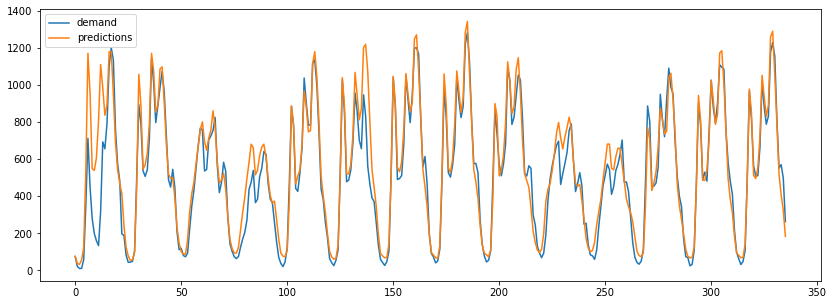

In [144]:
predictions = predictions.reset_index()
predictions = predictions['pred']
demand = test['rides']
demand = demand.reset_index()
demand = demand['rides']
#Plot of demand and predictions
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [145]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'Light GBM grid search', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533
2,Random Forest,16884.489419,86.475893,129.940330,0.823262
3,Random Forest grid search,13062.952660,69.379588,114.293275,0.880072
4,Random forest with exog. variables,22295.132267,99.223988,149.315546,0.825744
5,Random Forest with exog. variables grid search,18056.844368,93.056430,134.375758,0.796471
6,XGBoost,155785.599825,310.201150,394.696845,-6.386980
7,XGBoost with exog,106101.932726,251.882481,325.732916,-2.662770
8,XGBoost with exog,106101.932726,251.882481,325.732916,-2.662770
9,Light GBM,23815.884251,111.858306,154.323959,0.699046


The model Light gbm offers great results compared with the rest of the models, it is the second best model after the random forest.

#### Adding exogenous variables: weekday, is_holiday and hour

We saved our exogenous variables in a variable called columns_for_model

In [147]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),
                              lags=[24,24*7])
#Grid search to find best combination of hyperparameters

param_grid = {
    'n_estimators': [100,500],
    'max_depth': [3,5,10],
    'learning_rate': [0.01,0.1]
}

lags_grid = [[24,24*7],[24*7]]

grid_search = grid_search_forecaster(forecaster = forecaster,
                                    y = train['rides'],
                                    exog = train[columns_for_model],
                                    param_grid = param_grid,
                                    lags_grid = lags_grid,
                                    steps = steps,
                                    refit = False,
                                    metric = 'mean_squared_error',
                                    initial_train_size = int(len(train)*0.75),
                                    return_best=True,
                                    verbose=False)

loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Number of models compared: 24



loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:26<00:00, 13.03s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 24 168] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 25755.677204806816



In [148]:
#Backtesting to evaluate model

metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = rides_per_hour_models['rides'],
    exog = rides_per_hour_models[columns_for_model],
    initial_train_size = len(train),
    steps      = 24,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
)


In [150]:
#Feature importance
feature_importance = forecaster.get_feature_importance()
feature_importance.sort_values(by='importance', ascending = False, inplace=True)
feature_importance.head(10)

,feature,importance
0,lag_24,3844
1,lag_168,3256
3,weekday_Monday,751
46,is_weekend,648
45,is_holiday_x,618
37,month_5,399
2,weekday_Friday,312
40,month_8,193
7,weekday_Tuesday,186
15,hour_6,183


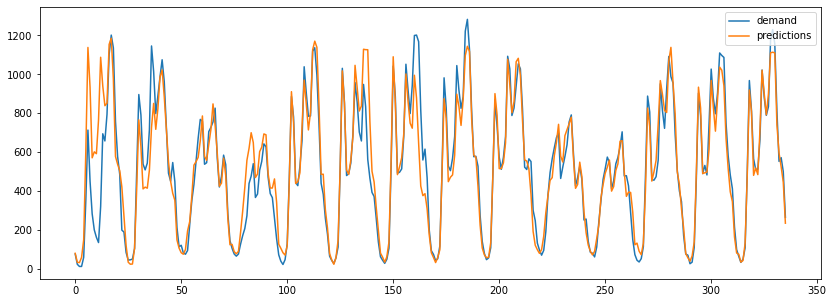

In [151]:
predictions = predictions.reset_index()
predictions = predictions['pred']
demand = test['rides']
demand = demand.reset_index()
demand = demand['rides']

#Plot of demand and predictions
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [152]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'Light GBM exog variables', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533
2,Random Forest,16884.489419,86.475893,129.940330,0.823262
3,Random Forest grid search,13062.952660,69.379588,114.293275,0.880072
4,Random forest with exog. variables,22295.132267,99.223988,149.315546,0.825744
5,Random Forest with exog. variables grid search,18056.844368,93.056430,134.375758,0.796471
6,XGBoost,155785.599825,310.201150,394.696845,-6.386980
7,XGBoost with exog,106101.932726,251.882481,325.732916,-2.662770
8,XGBoost with exog,106101.932726,251.882481,325.732916,-2.662770
9,Light GBM,23815.884251,111.858306,154.323959,0.699046


The results adding the exogenous variables is worse than the result taking into account only the lag values

In [153]:
#creating and training the forecaster

regressor = LGBMRegressor(learning_rate= 0.01, max_depth = 10, max_iter= 500)
forecaster = ForecasterAutoreg(regressor=regressor,
                              lags=24*7)
forecaster.fit(y=y_train)

#Obtaining exogenous variables for the model
steps = len(X_test)
last_day_data = rides_per_hour[-1:]
last_day_data = last_day_data.index[0]

exogenous_variables = pd.date_range(last_day_data, periods = 365*24,freq='H')
exogenous_variables = pd.DataFrame(exogenous_variables, columns = ['datetime'])
exogenous_variables = exogenous_variables[1:]
exogenous_variables['hour'] = exogenous_variables['datetime'].dt.hour
exogenous_variables['month'] = exogenous_variables['datetime'].dt.month
exogenous_variables['weekday'] = exogenous_variables['datetime'].dt.day_name()
exogenous_variables.reset_index(inplace=True)
exogenous_variables = pd.get_dummies(exogenous_variables, columns = ['weekday', 'hour', 'month'])
exogenous_variables = exogenous_variables[:steps]

#Obtaining the predictions and save them in the csv
predictions = forecaster.predict(steps=steps)
predictions = predictions.reset_index()

global_predictions = pd.concat([predictions, exogenous_variables], axis = 1)
global_predictions = global_predictions[['pred', 'datetime']]
global_predictions['hour'] = global_predictions['datetime'].dt.hour
global_predictions['day'] = global_predictions['datetime'].dt.date
global_predictions['model'] = 'Light GBM'

predictions_all_stations = predictions_all_stations.append(global_predictions)
predictions_all_stations.to_csv("predictions_all_stations.csv")

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


In [154]:
predictions_all_stations

,pred,datetime,hour,day,model
0,80.293696,2021-07-01 00:00:00,0,2021-07-01,Random Forest
1,43.352614,2021-07-01 01:00:00,1,2021-07-01,Random Forest
2,28.451396,2021-07-01 02:00:00,2,2021-07-01,Random Forest
3,40.465603,2021-07-01 03:00:00,3,2021-07-01,Random Forest
4,113.962771,2021-07-01 04:00:00,4,2021-07-01,Random Forest
...,...,...,...,...,...
331,794.429636,2021-07-14 19:00:00,19,2021-07-14,Light GBM
332,518.163809,2021-07-14 20:00:00,20,2021-07-14,Light GBM
333,408.455150,2021-07-14 21:00:00,21,2021-07-14,Light GBM
334,325.331607,2021-07-14 22:00:00,22,2021-07-14,Light GBM


#### 3.4.2.3. Cat Boost

In [156]:
#pip install catboost
from catboost import CatBoostRegressor

In [157]:
forecaster = ForecasterAutoreg(regressor = CatBoostRegressor(random_state=123, silent=True),
                              lags = [24*7,24])

#Grid search to find best combination of hyperparameters

param_grid = {
    'n_estimators': [100,500],
    'max_depth': [3,5,10],
    'learning_rate': [0.01,0.1]
}

lags_grid = [[24,24*7],[24*7]]

grid_search = grid_search_forecaster(forecaster = forecaster,
                                    y = train['rides'],
                                    exog = train[columns_for_model],
                                    param_grid = param_grid,
                                    lags_grid = lags_grid,
                                    steps = steps,
                                    refit = False,
                                    metric = 'mean_squared_error',
                                    initial_train_size = int(len(train)*0.75),
                                    return_best=True,
                                    verbose=False)

loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Number of models compared: 24



loop lags_grid: 100%|███████████████████████████████████████| 2/2 [02:13<00:00, 66.81s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 24 168] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 25667.199087988312



In [158]:
#Backtesting to evaluate model

metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = rides_per_hour_models['rides'],
    exog = rides_per_hour_models[columns_for_model],
    initial_train_size = len(train),
    steps      = 24,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
)


In [159]:
#Feature importance
feature_importance = forecaster.get_feature_importance()
feature_importance.sort_values(by='importance', ascending = False, inplace=True)
feature_importance

,feature,importance
0,lag_24,46.663853
1,lag_168,37.108779
46,is_weekend,4.237701
3,weekday_Monday,2.859922
45,is_holiday_x,1.669158
4,weekday_Saturday,1.339667
37,month_5,1.218103
2,weekday_Friday,0.580236
40,month_8,0.467638
44,month_12,0.416394


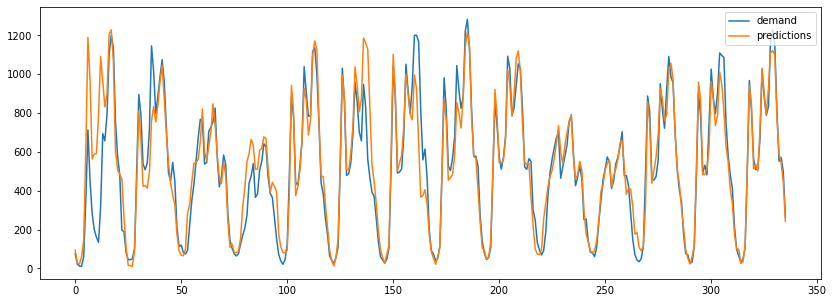

In [160]:
predictions = predictions.reset_index()
predictions = predictions['pred']
demand = test['rides']
demand = demand.reset_index()
demand = demand['rides']
#Plot of demand and predictions
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [162]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'Catboost exog variables', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,"ARIMA (24,0,6)",71991.659226,215.132376,268.312615,-1.565533
2,Random Forest,16884.489419,86.475893,129.940330,0.823262
3,Random Forest grid search,13062.952660,69.379588,114.293275,0.880072
4,Random forest with exog. variables,22295.132267,99.223988,149.315546,0.825744
5,Random Forest with exog. variables grid search,18056.844368,93.056430,134.375758,0.796471
6,XGBoost,155785.599825,310.201150,394.696845,-6.386980
7,XGBoost with exog,106101.932726,251.882481,325.732916,-2.662770
8,XGBoost with exog,106101.932726,251.882481,325.732916,-2.662770
9,Light GBM,23815.884251,111.858306,154.323959,0.699046


The results of the model are good if we compared it with the rest of the models. But they are worse than the random forest and the Light GBM models

In [169]:
#creating and training the forecaster

regressor = CatBoostRegressor(random_state=123, learning_rate= 0.1, max_depth = 5, n_estimators= 100)
forecaster = ForecasterAutoreg(regressor=regressor,
                              lags=24*7)
forecaster.fit(y = train['rides'], exog = train[columns_for_model])

#Obtaining exogenous variables for the model
steps = len(X_test)
last_day_data = rides_per_hour[-1:]
last_day_data = last_day_data.index[0]

exogenous_variables = pd.date_range(last_day_data, periods = 365*24,freq='H')
exogenous_variables = pd.DataFrame(exogenous_variables, columns = ['datetime'])
exogenous_variables = exogenous_variables[1:]
exogenous_variables['hour'] = exogenous_variables['datetime'].dt.hour
exogenous_variables['month'] = exogenous_variables['datetime'].dt.month
exogenous_variables['weekday'] = exogenous_variables['datetime'].dt.day_name()
exogenous_variables.reset_index(inplace=True)
exogenous_variables = pd.get_dummies(exogenous_variables, columns = ['weekday', 'hour', 'month'])
exogenous_variables = exogenous_variables[:steps]

#Obtaining the predictions and save them in the csv
predictions = forecaster.predict(steps=steps, exog = exogenous_variables[columns_for_model])
predictions = predictions.reset_index()

global_predictions = pd.concat([predictions, exogenous_variables], axis = 1)
global_predictions = global_predictions[['pred', 'datetime']]
global_predictions['hour'] = global_predictions['datetime'].dt.hour
global_predictions['day'] = global_predictions['datetime'].dt.date
global_predictions['model'] = 'Catboost'

predictions_all_stations = predictions_all_stations.append(global_predictions)
predictions_all_stations.to_csv("predictions_all_stations.csv")

0:	learn: 328.6175858	total: 12.4ms	remaining: 1.23s
1:	learn: 304.0729467	total: 24.5ms	remaining: 1.2s
2:	learn: 282.5410740	total: 35.8ms	remaining: 1.16s
3:	learn: 263.7794656	total: 48.7ms	remaining: 1.17s
4:	learn: 246.0494939	total: 61ms	remaining: 1.16s
5:	learn: 230.6957837	total: 72.3ms	remaining: 1.13s
6:	learn: 216.5456907	total: 83ms	remaining: 1.1s
7:	learn: 204.3973697	total: 93.8ms	remaining: 1.08s
8:	learn: 192.7517406	total: 105ms	remaining: 1.06s
9:	learn: 182.4995542	total: 116ms	remaining: 1.05s
10:	learn: 173.9112100	total: 127ms	remaining: 1.03s
11:	learn: 165.9058300	total: 139ms	remaining: 1.02s
12:	learn: 159.1410373	total: 151ms	remaining: 1.01s
13:	learn: 153.2719877	total: 163ms	remaining: 1s
14:	learn: 147.6948014	total: 174ms	remaining: 987ms
15:	learn: 142.6356857	total: 185ms	remaining: 970ms
16:	learn: 137.9944351	total: 195ms	remaining: 953ms
17:	learn: 133.8566521	total: 208ms	remaining: 949ms
18:	learn: 129.9478272	total: 222ms	remaining: 945ms
19:	

## 3.5. Conclusions